<img src="../../img/ICHEC_Logo.png" alt="Drawing" style="width: 500px;"/>

# <center> Exercises


****

# <center>**`cffi`**

### <center> 20 minutes
******

Consider the fibonacci code given below written in [`fibonacci.c`](./fibonacci.c). It requires the user to input a positive integer `n`, which is the number of terms to be performed by the `fibo` function, for which the arguments are two `int *`. 
    
The `fibo` function itself is utilised in a for loop.
    
Use either ABI in-line or API out-of-line methods as outlined above to import and implement this code.
    
Below is a skeleton code you can use to implement your library
    
```python
    
import numpy as np 
import time
    
# TODO (API) From newly created library import ffi, lib

# TODO (ABI) Open library and define function

# Number of terms in sequence
n = 10

# TODO: Define your pointer objects (HINT: there is no buffer and nothing to cast. Use this to create a new variable using ffi.new)
aptr = 
bptr = 
    
# Sets up the first two terms of fibonacci
aptr[0] = 0
bptr[0] = 1
    
# 
    
for i in range(n+1):
    # TODO: Call the function
    print(bptr[0]
```

#### <center> <b>Exercise 1: API out-of-line<b/>

* Create API_fibo.py
* Define the function using `ffibuilder.cdef`
* Find the relevant section of code in `fibonacci.c` and define it and the library using `ffibuilder.set_source`
* Run the file
* Edit the skeleton code above
* **Work outside the notebook to get more experience using the compute nodes**
<br><br>
<div class="alert alert-block alert-danger">
You may find a ImportError related to dynamic module export function. If this happens, try from a different directory
<div/>

In [4]:
%%writefile API_fibo.py

import cffi
ffibuilder = cffi.FFI()
ffibuilder.cdef("""void fibo(int *, int *);""")
ffibuilder.set_source("fibonacci._API_fibo", r"""
  void fibo(int *a, int *b)
  {
    int next;
    next = *a + *b;
    *b = *a;
    *a = next;
  }
  """)


if __name__ == "__main__":
    ffibuilder.compile(verbose=True)

Writing API_fibo.py


In [5]:
!python API_fibo.py

generating ./fibonacci/_API_fibo.c
the current directory is '/home/jupyter-cwerner/PyHPC-2022/04-CFFI/soln'
running build_ext
building 'fibonacci._API_fibo' extension
gcc -pthread -B /home/jupyter-cwerner/.conda/envs/python_hpc/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I/home/jupyter-cwerner/.conda/envs/python_hpc/include/python3.7m -c fibonacci/_API_fibo.c -o ./fibonacci/_API_fibo.o
gcc -pthread -shared -B /home/jupyter-cwerner/.conda/envs/python_hpc/compiler_compat -L/home/jupyter-cwerner/.conda/envs/python_hpc/lib -Wl,-rpath=/home/jupyter-cwerner/.conda/envs/python_hpc/lib -Wl,--no-as-needed -Wl,--sysroot=/ ./fibonacci/_API_fibo.o -o ./fibonacci/_API_fibo.cpython-37m-x86_64-linux-gnu.so


In [6]:
import numpy as np 
import time

from fibonacci._API_fibo import ffi, lib

n=10

# "pointer" objects
aptr = ffi.new("int *")
bptr = ffi.new("int *")

aptr[0] = 0
bptr[0] = 1

for i in range(n+1):
    lib.fibo(aptr, bptr)
    print(bptr[0])

0
1
1
2
3
5
8
13
21
34
55


#### <center>**Exercise 2: ABI in-line**
* Create a Makefile using the previous example as a template
* `make` the library
* Open the library using `ffi.dlopen`
* Edit the skeleton code
* **Work outside the notebook to get more experience using the compute nodes**


In [7]:
%%writefile Makefile
CC=gcc
CFLAGS=-fPIC -O3
LDFLAGS=-shared

fibonacci.so: fibonacci.c
	$(CC) -o fibonacci.so $(LDFLAGS) $(CFLAGS) fibonacci.c

Writing Makefile


In [8]:
!ls

04-Soln-cffi.ipynb  bottle_large.dat  fibonacci		       Makefile
API_fibo.py	    evolve.c	      fibonacci.c
bottle.dat	    evolve.h	      heat_equation_simple.py


In [9]:
!make

gcc -o fibonacci.so -shared -fPIC -O3 fibonacci.c
fibonacci.c: In function ‘main’:
fibonacci.c:12:5: warning: ignoring return value of ‘scanf’, declared with attribute warn_unused_result [-Wunused-result]
     scanf("%d",&n);
     ^~~~~~~~~~~~~~


In [10]:
from cffi import FFI
import numpy as np
import time 

ffi = FFI()
lib = ffi.dlopen('./fibonacci.so')
ffi.cdef("void fibo(int *, int *);")

n=10

# "pointer" objects
aptr = ffi.new("int *")
bptr = ffi.new("int *")

aptr[0] = 0
bptr[0] = 1

print(aptr[0])

for i in range(n+1):
    lib.fibo(aptr, bptr)
    print(aptr[0])

0
1
1
2
3
5
8
13
21
34
55
89


***
### <center>**Bonus Exercises**
    
This exercise is based on `evolve.py` which we use a few times during this course. You can implement this in either ABI or API modes, or both! 
    
**All existing file names are linked. You may wish to create a few copies of [`heat_equation_simple.py`](./heat_equation_simple.py) for different methods**

<br>
    
#### <center> **Exercise 3: `evolve.py`**
    
**API mode:**
    
 By copying and pasting the C code in [`evolve.c`](./evolve.c) edit the build file below to utilize the C code using API out-line mode. 
  - Run the build file to create the library
  - Import your newly created library back into [`heat_equation_simple.py`](./heat_equation_simple.py).
   

In [11]:
%%writefile API_build.py

import cffi
ffibuilder = cffi.FFI()
ffibuilder.set_source("package._out", r"""
void evolve(double *u, double *u_previous, int nx, int ny, 
            double a, double dt, double dx2, double dy2)
{
  int i, j;
  int ij, ip, im, jp, jm;

  for (i=1; i < nx-1; i++)
    for (j=1; j < ny-1; j++) {
      // Linearisation for 2D array
      ij = j + i*nx;
      ip = j + (i+1)*nx;
      im = j + (i-1)*nx;
      jp = (j + 1) + i*nx;
      jm = (j - 1) + i*nx;
      u[ij] = u_previous[ij] + a * dt * ( 
              (u_previous[ip] - 2*u_previous[ij] + u_previous[im]) / dx2 + 
              (u_previous[jp] - 2*u_previous[ij] + u_previous[jm]) / dy2 );
      }

  memcpy(u_previous, u, nx*ny*sizeof(double));
}
""")
ffibuilder.cdef("""
            void evolve(double *, double *, int, int, double, double, double, double);
        """)

if __name__ == "__main__":
    ffibuilder.compile(verbose=True)

Writing API_build.py


In [12]:
!python API_build.py

generating ./package/_out.c
the current directory is '/home/jupyter-cwerner/PyHPC-2022/04-CFFI/soln'
running build_ext
building 'package._out' extension
gcc -pthread -B /home/jupyter-cwerner/.conda/envs/python_hpc/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I/home/jupyter-cwerner/.conda/envs/python_hpc/include/python3.7m -c package/_out.c -o ./package/_out.o
gcc -pthread -shared -B /home/jupyter-cwerner/.conda/envs/python_hpc/compiler_compat -L/home/jupyter-cwerner/.conda/envs/python_hpc/lib -Wl,-rpath=/home/jupyter-cwerner/.conda/envs/python_hpc/lib -Wl,--no-as-needed -Wl,--sysroot=/ ./package/_out.o -o ./package/_out.cpython-37m-x86_64-linux-gnu.so


Using cffi (API) Running Time: 0.022667646408081055


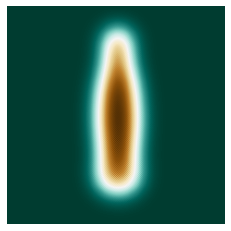

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import time

from package._out import ffi, lib

# Set the colormap
plt.rcParams['image.cmap'] = 'BrBG'

# Basic parameters
a = 0.5                # Diffusion constant
timesteps = 200        # Number of time-steps to evolve system
image_interval = 4000  # Write frequency for png files

# Grid spacings
dx = 0.01
dy = 0.01
dx2 = dx**2
dy2 = dy**2

# For stability, this is the largest interval possible
# for the size of the time-step:
dt = dx2*dy2 / ( 2*a*(dx2+dy2) )

def initial_fields(filename):
    field = np.loadtxt(filename)
    field0 = np.copy(field)
    return field, field0

def write_field(field, step):
    plt.gca().clear()
    #plt.hold(False)
    plt.imshow(field)
    plt.axis('off')
    plt.savefig('heat_{0:03d}.png'.format(step))

def iterate(field, field0, timesteps, image_interval):
    '''Same as ABI Mode'''
     ###
    field_ptr = ffi.cast("double *", ffi.from_buffer(field))
    field0_ptr = ffi.cast("double *", ffi.from_buffer(field0))
    nx, ny = field.shape

    for i in range(1,timesteps+1):
        lib.evolve(field_ptr, field0_ptr, nx, ny, a, dt, dx2, dy2)
        if i % image_interval == 0:
            write_field(field, i)

def main():
    filename = sys.argv[1]
    field, field0 = initial_fields('bottle.dat')

    write_field(field, 0)

    t0 = time.time()
    iterate(field, field0, timesteps, image_interval)
    t1 = time.time()

    write_field(field, timesteps)

    print ("Using cffi (API) Running Time: {0}".format(t1-t0))

main()

**ABI mode:**

The files [`evolve.h`](./evolve.h) and [`evolve.c`](./evolve.c) contain a pure C implementation of the single time step in the heat equation. The C implementation can be built into a shared library with the provided [`Makefile`](./Makefile) by executing the `make` command. 
- Edit the [`heat_equation_simple.py`](./heat_equation_simple.py) file to use cffi in the ABI in-line mode.
  -  Utilize the library function instead of the Python function. 

<div class="alert alert-block alert-danger">
Beware of having multiple Makefiles in the same directory.
<div/>

In [16]:
!make

gcc -o libevolve.so -shared -fPIC -O3 evolve.c


Index and cffi (ABI) Running Time: 0.015126943588256836


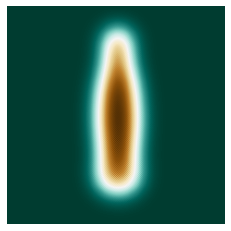

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import time

from cffi import FFI 
ffi = FFI()
lib = ffi.dlopen("./libevolve.so") #./ when using functions from users own library
ffi.cdef("""void evolve(double *u, double *u_previous, int nx, int ny, double a, double dt, double dx2, double dy2);""")


plt.rcParams['image.cmap'] = 'BrBG'

# Basic parameters
a = 0.5                # Diffusion constant
timesteps = 200        # Number of time-steps to evolve system
image_interval = 4000  # Write frequency for png files

# Grid spacings
dx = 0.01
dy = 0.01
dx2 = dx**2
dy2 = dy**2

# For stability, this is the largest interval possible
# for the size of the time-step:
dt = dx2*dy2 / ( 2*a*(dx2+dy2) )

def initial_fields(filename):
    field = np.loadtxt(filename)
    field0 = np.copy(field)
    return field, field0

def write_field(field, step):
    plt.gca().clear()
    #plt.hold(False)
    plt.imshow(field)
    plt.axis('off')
    plt.savefig('heat_{0:03d}.png'.format(step))

def iterate(field, field0, timesteps, image_interval): 
    
    '''New Stuff'''
    ###
    field_ptr = ffi.cast("double *", ffi.from_buffer(field))
    field0_ptr = ffi.cast("double *", ffi.from_buffer(field0))
    nx, ny = field.shape

    for i in range(1,timesteps+1):
        lib.evolve(field_ptr, field0_ptr, nx, ny, a, dt, dx2, dy2)
        if i % image_interval == 0:
            write_field(field, i)
    ###

def main():
    field, field0 = initial_fields('bottle.dat')

    write_field(field, 0)

    t0 = time.time()
    iterate(field, field0, timesteps, image_interval)
    t1 = time.time()

    write_field(field, timesteps)

    print ("Index and cffi (ABI) Running Time: {0}".format(t1-t0))


main()